In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
from imutils.contours import sort_contours
import imutils
import pathlib

In [4]:
data_dir = pathlib.Path('../projekat/handwritten/dataset')

In [5]:
import splitfolders
splitfolders.ratio(data_dir, output="output", seed=1337, ratio=(.8, 0.1,0.1))

Copying files: 9008 files [00:28, 312.45 files/s]


In [6]:
train_path = "./output/train"
test_path  = "./output/test"
val_path = "./output/val"

In [8]:
import os
import pandas as pd
from glob import glob
import numpy as np 
import matplotlib.pyplot as plt
from matplotlib.image import imread 
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D, BatchNormalization,GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator


from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam, Adamax
%matplotlib inline

In [9]:
image_shape = (100,100,3)
epochs = 8
batch_size = 32

In [12]:
traindata_gen=ImageDataGenerator(
                             rotation_range=10,
                             rescale=1.0/255,
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             shear_range=0.1,
                              zoom_range=0.1,
                             fill_mode='nearest'
                              )

testdata_gen=ImageDataGenerator(
                             
                             rescale=1.0/255,)

valdatagen = ImageDataGenerator(
                           rescale=1.0/255,
                    )

In [13]:
train_set=traindata_gen.flow_from_directory(train_path,
                                              target_size =image_shape[:2],
                                                 batch_size = batch_size,
                                                 class_mode = 'categorical',
                                           shuffle=True,
                                           seed=3301)

test_set=testdata_gen.flow_from_directory(test_path,
                                            target_size = image_shape[:2],
                                                 batch_size = batch_size,
                                                 class_mode = 'categorical',
                                            shuffle=False)
val_set = valdatagen.flow_from_directory(val_path,
                                            target_size = image_shape[:2],
                                                 batch_size = batch_size,
                                                 class_mode = 'categorical',
                                            shuffle=True )

Found 7199 images belonging to 16 classes.
Found 915 images belonging to 16 classes.
Found 894 images belonging to 16 classes.


In [14]:
class_labels = list(train_set.class_indices.keys())   
num_classes = len(class_labels)
print(class_labels)

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'add', 'dec', 'div', 'eq', 'mul', 'sub']


In [ ]:
plt.figure(figsize=(12, 12))
for images, labels in test_set:
    for i in range(9):
        plt.subplot(330 + 1 + i)
        image = images[i]
        label = class_labels[np.argmax(labels[i])]
        plt.imshow(image)
        plt.title(label)
    break

In [ ]:
plt.figure(figsize=(12, 12))
for img_batch,label_batch in train_set:
    for i in range(9):
        plt.subplot(330 + 1 + i)
        image = images[i]
        label = class_labels[np.argmax(labels[i])]
        tx_img = traindata_gen.random_transform(image)
        plt.imshow(tx_img)
        plt.title('Augmented Image ' + label)
        
    break

In [22]:
image_shape = (100,100,3)
epochs = 8
batch_size = 32

In [28]:
base_model=tf.keras.applications.MobileNetV2( include_top=False, input_shape=image_shape, pooling='max', weights='imagenet') 
base_model.trainable = False
x=base_model.output

x=BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
x = Dense(1024, kernel_regularizer = regularizers.l2(l = 0.016) ,activation='relu', kernel_initializer= tf.keras.initializers.GlorotUniform(seed=123))(x)

x=Dropout(rate=.3, seed=123)(x)         

output=Dense(num_classes, activation='softmax',kernel_initializer=tf.keras.initializers.GlorotUniform(seed=123))(x)

model=Model(inputs=base_model.input, outputs=output)
model.compile(Adamax(learning_rate=.001), loss='categorical_crossentropy', metrics=['accuracy'])  

early_stop=tf.keras.callbacks.EarlyStopping( monitor="val_loss",  patience=2, verbose=1,restore_best_weights=True)

In [31]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 50, 50, 32)   864         ['input_6[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 50, 50, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 50, 50, 32)   0           ['bn_Conv1[0][0]']         

In [35]:
result = model.fit(
  train_set,
  epochs=epochs,
  validation_data=val_set,
  callbacks=[early_stop]
    
)

Epoch 1/8
225/225 [==============================] - 14s 61ms/step - loss: 3.2493 - accuracy: 0.9376 - val_loss: 1.7820 - val_accuracy: 0.9418
Epoch 2/8
225/225 [==============================] - 14s 60ms/step - loss: 1.1777 - accuracy: 0.9493 - val_loss: 0.7784 - val_accuracy: 0.9508
Epoch 3/8
225/225 [==============================] - 14s 61ms/step - loss: 0.6263 - accuracy: 0.9458 - val_loss: 0.5036 - val_accuracy: 0.9497
Epoch 4/8
225/225 [==============================] - 13s 59ms/step - loss: 0.4593 - accuracy: 0.9480 - val_loss: 0.4270 - val_accuracy: 0.9497
Epoch 5/8
225/225 [==============================] - 14s 61ms/step - loss: 0.4006 - accuracy: 0.9517 - val_loss: 0.3810 - val_accuracy: 0.9530
Epoch 6/8
225/225 [==============================] - 13s 59ms/step - loss: 0.3840 - accuracy: 0.9508 - val_loss: 0.3777 - val_accuracy: 0.9485
Epoch 7/8
225/225 [==============================] - 14s 61ms/step - loss: 0.3757 - accuracy: 0.9503 - val_loss: 0.3662 - val_accuracy: 0.9530

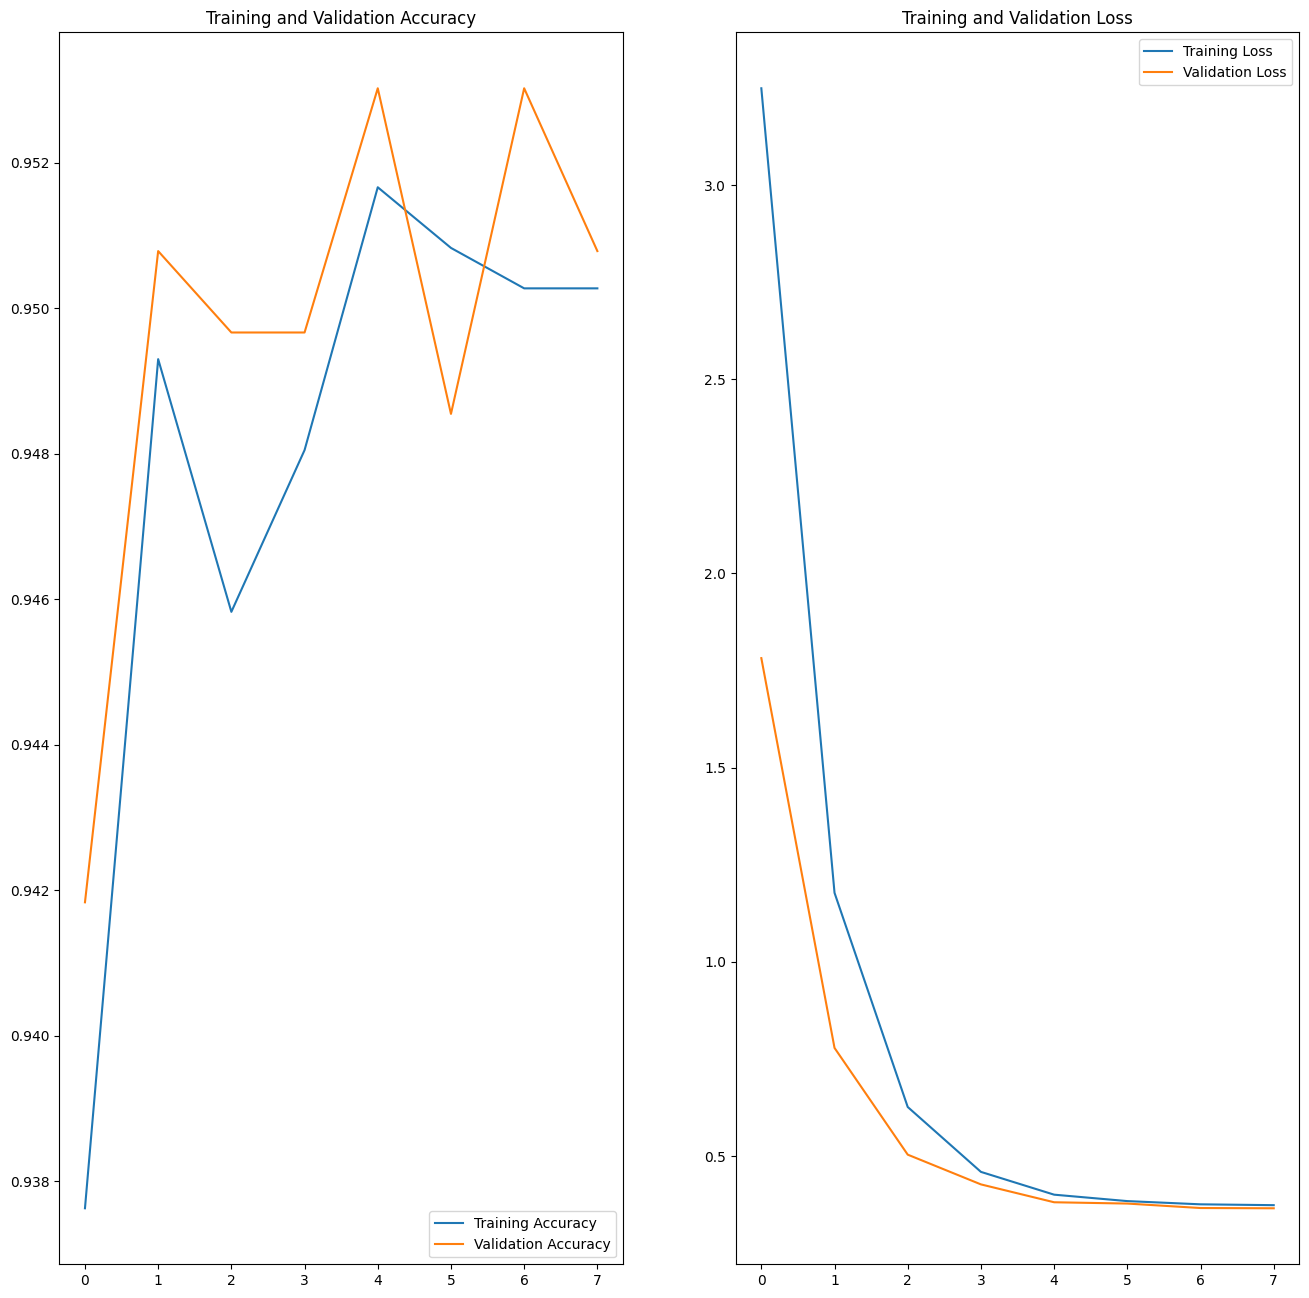

In [36]:
acc = result.history['accuracy']
val_acc = result.history['val_accuracy']

loss = result.history['loss']
val_loss = result.history['val_loss']


epochs_range = range(epochs)

plt.figure(figsize=(16, 16))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [37]:
test_steps_per_epoch = np.math.ceil(test_set.samples / test_set.batch_size)

predictions = model.predict(test_set, steps=test_steps_per_epoch)
# Get most likely class
predicted_classes = np.argmax(predictions, axis=1)

true_classes = test_set.classes
class_labels = list(test_set.class_indices.keys())   

from sklearn.metrics import  classification_report
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report) 

29/29 [==============================] - 4s 108ms/step
              precision    recall  f1-score   support

           0       0.88      1.00      0.94        60
           1       0.98      1.00      0.99        57
           2       0.91      0.98      0.95        44
           3       0.98      0.85      0.91        55
           4       0.94      0.87      0.90        54
           5       0.83      0.98      0.90        44
           6       1.00      0.86      0.93        59
           7       0.96      0.96      0.96        54
           8       0.98      0.96      0.97        56
           9       0.93      0.96      0.95        56
         add       1.00      1.00      1.00        61
         dec       1.00      0.98      0.99        63
         div       0.98      0.97      0.98        63
          eq       0.97      0.94      0.95        64
         mul       0.97      0.98      0.97        59
         sub       0.99      1.00      0.99        66

    accuracy             

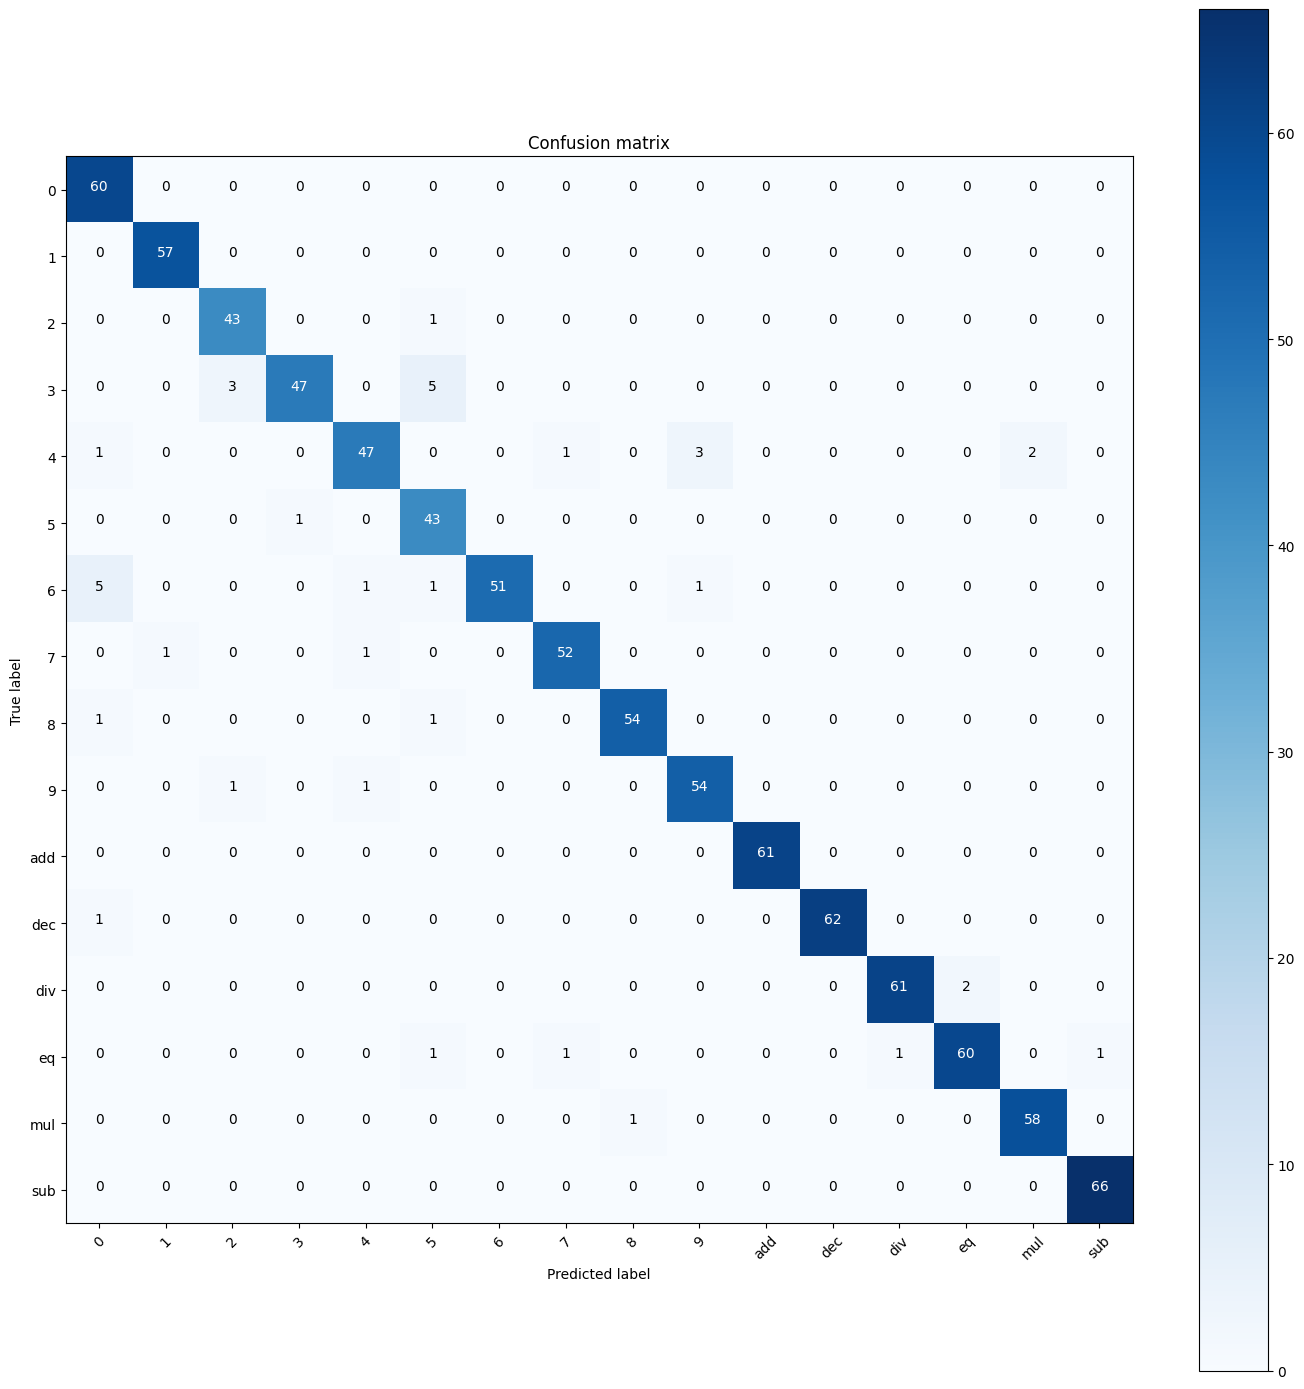

In [38]:
import itertools
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# compute the confusion matrix
confusion_mtx = confusion_matrix(true_classes, predicted_classes) 
# plot the confusion matrix

plt.figure(figsize=(14, 14))
plot_confusion_matrix(confusion_mtx, classes = class_labels) 

In [55]:
from keras.utils import load_img, img_to_array
from keras.applications.mobilenet_v2 import preprocess_input

#load the image
my_image = load_img('../projekat/characters/2.png', target_size=image_shape)

#preprocess the image
my_image = img_to_array(my_image)
my_image = my_image.reshape((1, my_image.shape[0], my_image.shape[1], my_image.shape[2]))
my_image = preprocess_input(my_image)

#make the prediction
prediction = model.predict(my_image)

1/1 [==============================] - 0s 22ms/step


In [56]:
prediction

array([[2.0347019e-03, 1.4124418e-03, 1.3839132e-02, 1.4019795e-02,
        6.7206502e-02, 4.1930764e-03, 3.9862460e-03, 1.6167721e-02,
        8.8848053e-03, 8.5159540e-01, 2.0109248e-04, 3.6526372e-04,
        1.7377738e-03, 3.9920555e-03, 9.7039742e-03, 6.6006184e-04]],
      dtype=float32)

In [54]:
class_labels[ np.argmax([np.round(x) for x in prediction]) ]

'2'